# MiniDiffusion

## Project Setup

### Notebook Setup Instructions

Ensure the following prerequisites are installed and configured:

1. **PyTorch Installation**  
   **Version Used:** PyTorch 2.5.1  
   Install PyTorch according to your system specifications:  
   Refer to the official guide: [https://pytorch.org/get-started/locally/](https://pytorch.org/get-started/locally/)

2. **CUDA Compatibility**  
    **Version Required:** CUDA 12.4  
    Ensure your system has compatible GPU drivers installed.  
    Download and install CUDA: [CUDA 12.4 Download](https://developer.nvidia.com/cuda-12-4-0-download-archive)

4. **Python Version**  
    **Version Required:** Python 3.12.8  
    Download and install Python: [Download Python 3.12.8](https://www.python.org/downloads/release/python-3128/)

5. **Rust Installation**  
    Rust is required for certain dependencies.  
    Download and install Rust: [rustup](https://rustup.rs/)


### Install Required Dependencies

Install necessary Python packages.


In [24]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
%pip install --upgrade diffusers accelerate transformers
%pip install pillow
%pip install ipywidgets tqdm --upgrade


Looking in indexes: https://download.pytorch.org/whl/cu124
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Import Libraries and Modules

Imports necessary libraries and modules for the MiniDiffusion project.


In [25]:
import os
import torch
from diffusers import DiffusionPipeline, AutoencoderKL, UNet2DConditionModel, EulerAncestralDiscreteScheduler, UniPCMultistepScheduler
from diffusers.utils import make_image_grid
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm import tqdm
from PIL import Image


### Directory Structure

Ensure the following directories exist or are created.


In [26]:
# Set directories for project
assets_dir = "./assets"
images_path = "./images"

# Define directories for cache, models, and vae
cache_dir = os.path.join(assets_dir, "cache")
models_dir = os.path.join(assets_dir, "models")
models_cache_dir = os.path.join(cache_dir, "models")
vae_dir = os.path.join(assets_dir, "vae")
vae_cache_dir = os.path.join(cache_dir, "vae")

# Ensure all directories exist
os.makedirs(assets_dir, exist_ok=True)
os.makedirs(images_path, exist_ok=True)
os.makedirs(cache_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(models_cache_dir, exist_ok=True)
os.makedirs(vae_dir, exist_ok=True)
os.makedirs(vae_cache_dir, exist_ok=True)


### Device Configuration

Set the device based on the availability of CUDA.


In [27]:
# Set device based on availability of CUDA
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch_dtype = torch.float16


### Default Parameters

In [28]:
# Scheduler and pipeline defaults
scheduler = EulerAncestralDiscreteScheduler
prompt = "portrait photo of an old warrior chief"
num_inference_steps = 20
generator = torch.manual_seed(0)

### Utility Functions

Define helper functions to streamline common tasks.


In [46]:
def load_model(model_class, pretrained_model_path, pretrained_model_name, cache_dir, description, torch_dtype=None, device=None, subfolder=None):
    """
    Load a model from a local path or download it from the Hugging Face Hub.

    Args:
        model_class (class): The class of the model to load (e.g., AutoencoderKL, DiffusionPipeline).
        pretrained_model_path (str): The local path to the model.
        pretrained_model_name (str): The name of the model on the Hugging Face Hub.
        cache_dir (str): Directory to cache the downloaded model files.
        description (str): A short description of the model being loaded, used for log messages.
        torch_dtype (torch.dtype): The PyTorch data type to load the model with (e.g., torch.float16).
        device (str): The device to load the model onto (e.g., 'cuda' or 'cpu').
        subfolder (str): The subfolder within the repository where the model component is stored.

    Returns:
        model: The loaded model, either from the local path or the Hugging Face Hub.
    """
    # Prepare arguments for from_pretrained
    kwargs = {}
    
    # Add torch_dtype if applicable
    if torch_dtype:
        kwargs['torch_dtype'] = torch_dtype

    if os.path.exists(pretrained_model_path):
        print(f"Loading {description} from local path: {pretrained_model_path}...")
        model = model_class.from_pretrained(
            pretrained_model_path,
            **kwargs
        )
    else:
        # Add subfolder if applicable
        if subfolder:
            kwargs['subfolder'] = subfolder

        print(f"Downloading {description} from Hugging Face Hub: {pretrained_model_name} (subfolder: {subfolder})...")
        model = model_class.from_pretrained(
            pretrained_model_name, 
            cache_dir=cache_dir,
            **kwargs
        )
        
        # Save the model locally for future use
        model.save_pretrained(pretrained_model_path)
        print(f"{description} downloaded and saved to {pretrained_model_path}.")

    # Move the model to the specified device if applicable
    if hasattr(model, "to") and device is not None:
        model = model.to(device)
    
    return model


def get_inputs(batch_size=1, num_inference_steps=num_inference_steps):
    """
    Generate input parameters for the diffusion pipeline.

    Args:
        batch_size (int): The number of images to generate in a single batch. Default is 1.
        num_inference_steps (int): The number of denoising steps for the pipeline. Default is 20.

    Returns:
        dict: A dictionary containing the inputs for the pipeline.
    """
    if not prompt:
        raise ValueError("Prompt cannot be empty. Please provide a valid prompt.")

    # Create a list of random number generators with different seeds for each batch item
    generator = [torch.Generator("cuda").manual_seed(i) for i in range(batch_size)]

    # Replicate the prompt for the batch size
    prompts = batch_size * [prompt]

    return {"prompt": prompts, "generator": generator, "num_inference_steps": num_inference_steps}

def save_image(image, filename, folder_path=images_path):
    """
    Saves an image to the specified folder with a given filename.
    
    Parameters:
    - image (PIL.Image): The image object to save.
    - filename (str): The name of the image file (e.g., 'output.png').
    - folder_path (str): The directory to save the image in.
    
    Returns:
        str: The full path to the saved image.
    """
    if not isinstance(filename, str) or not filename.endswith(('.png', '.jpg', '.jpeg')):
        raise ValueError("Filename must be a valid image file with a .png, .jpg, or .jpeg extension.")

    # Ensure the folder exists
    os.makedirs(folder_path, exist_ok=True)
    
    # Construct the full image path
    image_path = os.path.join(folder_path, filename)
    
    # Save the image
    image.save(image_path)
    print(f"Image saved to: {image_path}")

    return image_path


## Using a Pipeline

### Model Configuration

Configure the model.


In [30]:
# Predefined model names and paths
pretrained_model_name = "stable-diffusion-v1-5/stable-diffusion-v1-5"
pretrained_model_path = os.path.join(models_dir, pretrained_model_name)
pretrained_vae_name = "stabilityai/sd-vae-ft-mse"
pretrained_vae_path = os.path.join(vae_dir, pretrained_vae_name)


### Model Loading

Load the VAE and Diffusion Pipeline models.


In [31]:
# Reload models if necessary
force_reload = True

# Load or download VAE
vae = None if force_reload else vae  # Ensure reload if force_reload is True
vae = vae or load_model(
    model_class=AutoencoderKL,
    pretrained_model_path=pretrained_vae_path,
    pretrained_model_name=pretrained_vae_name,
    cache_dir=vae_cache_dir,
    torch_dtype=torch_dtype,
    device=device,
    description="VAE model"
)

# Load or download pipeline
pipeline = None if force_reload else pipeline  # Ensure reload if force_reload is True
pipeline = pipeline or load_model(
    model_class=DiffusionPipeline,
    pretrained_model_path=pretrained_model_path,
    pretrained_model_name=pretrained_model_name,
    cache_dir=models_cache_dir,
    torch_dtype=torch_dtype,
    device=device,
    description="Diffusion pipeline"
)

# Assign VAE and scheduler to the pipeline
pipeline.vae = vae
pipeline.scheduler = scheduler.from_config(pipeline.scheduler.config)

print("All models loaded and configured successfully.")


Loading VAE model from local path: ./assets\vae\stabilityai/sd-vae-ft-mse...
Loading Diffusion pipeline from local path: ./assets\models\stable-diffusion-v1-5/stable-diffusion-v1-5...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

All models loaded and configured successfully.


### Image Generation

Generate and save images.


  0%|          | 0/20 [00:00<?, ?it/s]

Image saved to: ./images\single_output.png


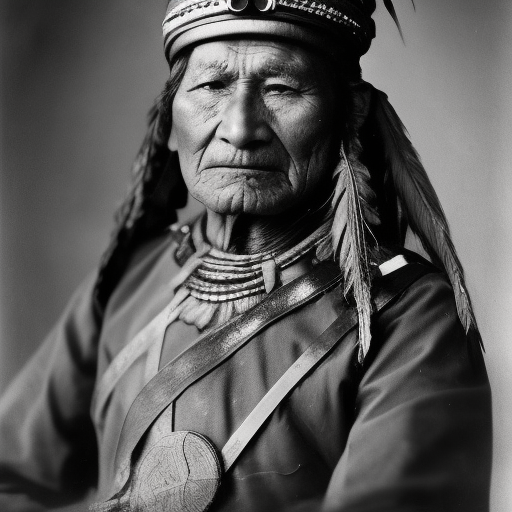

In [32]:
# Single image generation
image = pipeline(prompt=prompt, generator=generator, num_inference_steps=num_inference_steps).images[0]
save_image(image, "single_output.png")
image


  0%|          | 0/20 [00:00<?, ?it/s]

Image saved to: ./images\batch_output_grid.png


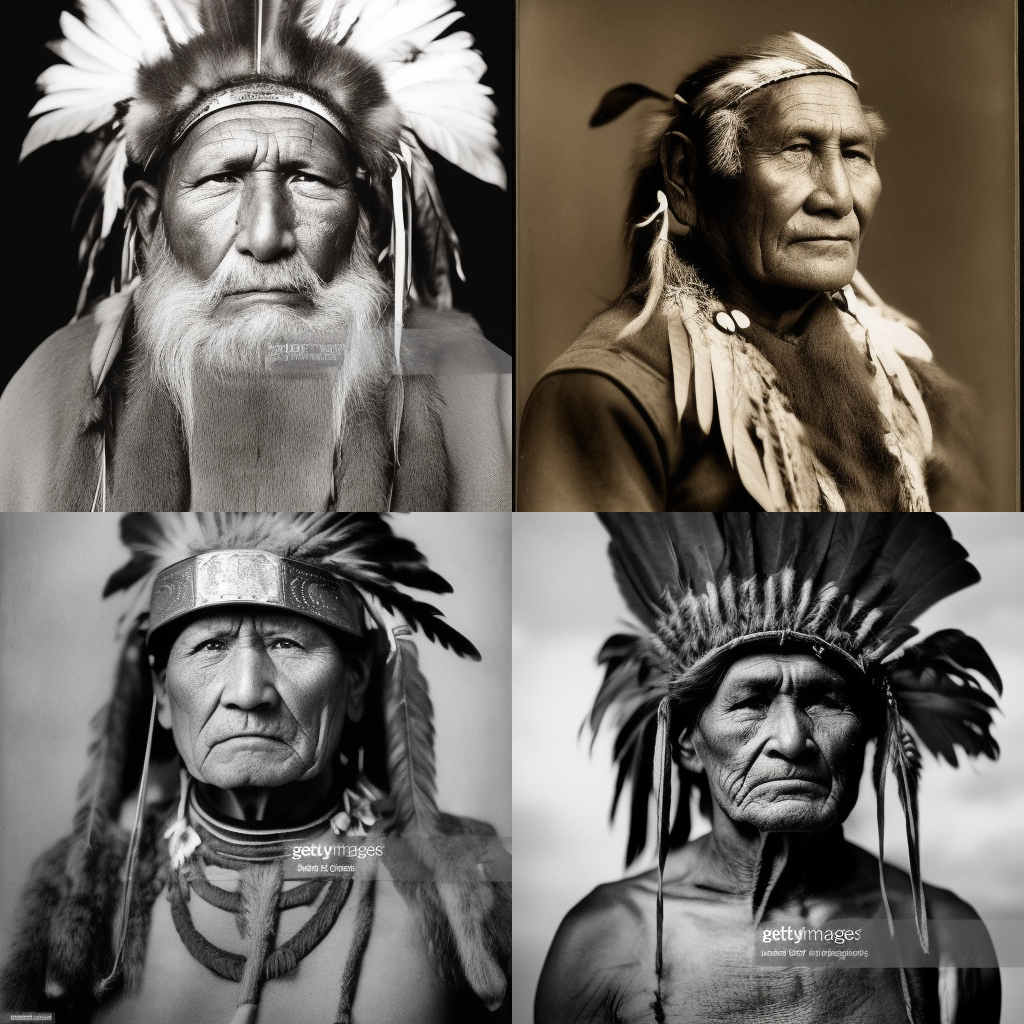

In [33]:
# Batch image generation
batch_inputs = get_inputs(batch_size=4)
images = pipeline(**batch_inputs).images

# Save and display batch results
grid_image = make_image_grid(images, rows=2, cols=2)
save_image(grid_image, "batch_output_grid.png")
grid_image


## Without a Pipeline

### Scheduler Properties

In this section, we explore some of the properties of the diffusion pipeline scheduler.


In [34]:
# Explore the scheduler properties of the pipeline

# List compatible schedulers available in the pipeline
scheduler_classes = [cls.__name__ for cls in pipeline.scheduler.compatibles]
print("Compatible schedulers:\n", scheduler_classes)

# Check the timesteps of the scheduler
print("\nScheduler timesteps:\n", pipeline.scheduler.timesteps)


Compatible schedulers:
 ['KDPM2DiscreteScheduler', 'PNDMScheduler', 'UniPCMultistepScheduler', 'EulerAncestralDiscreteScheduler', 'LMSDiscreteScheduler', 'DPMSolverMultistepScheduler', 'DPMSolverSinglestepScheduler', 'DDIMScheduler', 'DPMSolverSDEScheduler', 'EDMEulerScheduler', 'EulerDiscreteScheduler', 'KDPM2AncestralDiscreteScheduler', 'DDPMScheduler', 'DEISMultistepScheduler', 'HeunDiscreteScheduler']

Scheduler timesteps:
 tensor([951., 901., 851., 801., 751., 701., 651., 601., 551., 501., 451., 401.,
        351., 301., 251., 201., 151., 101.,  51.,   1.], device='cuda:0')


### Initialize Pretrained Models

In [52]:
# Define the model
pretrained_model_name = "CompVis/stable-diffusion-v1-4"

# Define paths for model components
vae_path = os.path.join(models_dir, "vae")
text_encoder_path = os.path.join(models_dir, "text_encoder")
unet_path = os.path.join(models_dir, "unet")
tokenizer_path = os.path.join(models_dir, "tokenizer")
scheduler_path = os.path.join(models_dir, "scheduler")

# Load components using the load_model function
vae = load_model(
    model_class=AutoencoderKL,
    pretrained_model_path=vae_path,
    pretrained_model_name=pretrained_model_name,
    cache_dir=vae_cache_dir,
    # torch_dtype=torch_dtype,
    device=device,
    description="VAE",
    subfolder="vae"
)

text_encoder = load_model(
    model_class=CLIPTextModel,
    pretrained_model_path=text_encoder_path,
    pretrained_model_name=pretrained_model_name,
    cache_dir=models_cache_dir,
    # torch_dtype=torch_dtype,
    device=device,
    description="Text Encoder",
    subfolder="text_encoder"
)

unet = load_model(
    model_class=UNet2DConditionModel,
    pretrained_model_path=unet_path,
    pretrained_model_name=pretrained_model_name,
    cache_dir=models_cache_dir,
    # torch_dtype=torch_dtype,
    device=device,
    description="UNet",
    subfolder="unet"
)

tokenizer = load_model(
    model_class=CLIPTokenizer,
    pretrained_model_path=tokenizer_path,
    pretrained_model_name=pretrained_model_name,
    cache_dir=models_cache_dir,
    description="Tokenizer",
    subfolder="tokenizer"
)

scheduler = load_model(
    model_class=UniPCMultistepScheduler,
    pretrained_model_path=scheduler_path,
    pretrained_model_name=pretrained_model_name,
    cache_dir=models_cache_dir,
    description="Scheduler",
    subfolder="scheduler"
)


Loading VAE from local path: ./assets\models\vae...
Loading Text Encoder from local path: ./assets\models\text_encoder...
Loading UNet from local path: ./assets\models\unet...
Loading Tokenizer from local path: ./assets\models\tokenizer...
Loading Scheduler from local path: ./assets\models\scheduler...


### Define Parameters

In [53]:
# Define generation parameters
prompt = ["a photograph of an astronaut riding a horse"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator to create the initial latent noise
batch_size = len(prompt)


### Tokenize Input Prompt

In [54]:
# Tokenize the text input
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

# Get text embeddings
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

# Prepare unconditional embeddings for classifier-free guidance
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

# Combine unconditional and conditional embeddings
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])


### Initialize Latents

In [55]:
# Initialize random latent noise

latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
).to(device)
latents = latents * scheduler.init_noise_sigma


### Denoising Loop

In [56]:
# Set scheduler timesteps
scheduler.set_timesteps(num_inference_steps)

# Denoising loop
for t in tqdm(scheduler.timesteps):
    # Expand latents for classifier-free guidance
    latent_model_input = torch.cat([latents] * 2)

    # Scale the model input
    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # Predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Perform classifier-free guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Update latents (Compute the previous noisy sample x_t -> x_t-1)
    latents = scheduler.step(noise_pred, t, latents).prev_sample



00%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  4.07it/s]

### Decode Latents to Image

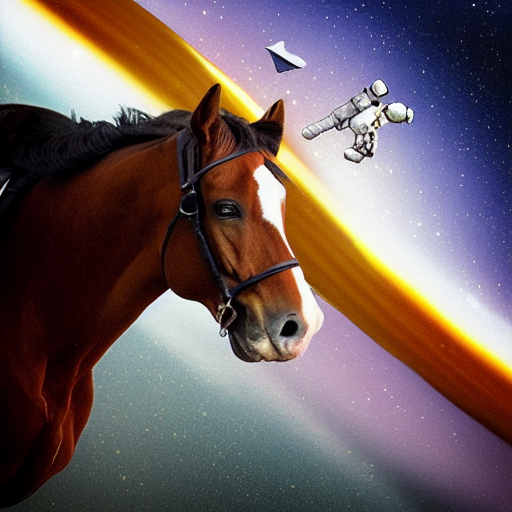

In [57]:
# Scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Post-process the image
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)

# Display the final image
image
